
<a id='parallel'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Multithreading with Numba

**John Stachurski** September 2023

Install if you haven't yet (uncomment)

In [1]:
#!pip install quantecon

## Overview

The growth of CPU clock speed (i.e., the speed at which a single chain of logic can
be run) has slowed dramatically in recent years.

This is unlikely to change in the near future, due to inherent physical
limitations on the construction of chips and circuit boards.

Chip designers and computer programmers have responded to the slowdown by
seeking a different path to fast execution: parallelization.

Hardware makers have increased the number of cores (physical CPUs) embedded in each machine.

For programmers, the challenge has been to exploit these multiple CPUs by running many processes in parallel (i.e., simultaneously).

This is particularly important in scientific programming, which requires handling

- large amounts of data and  
- CPU intensive simulations and other calculations.  


In this lecture we discuss parallelization for scientific computing, with a focus on

1. the best tools for parallelization in Python and  
1. how these tools can be applied to quantitative economic problems.  


Let’s start with some imports:

In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

## Types of Parallelization

Large textbooks have been written on different approaches to parallelization but we will keep a tight focus on what’s most useful to us.

We will briefly review the two main kinds of parallelization commonly used in
scientific computing and discuss their pros and cons.

### Multiprocessing

Multiprocessing means concurrent execution of multiple processes using more than one processor.

In this context, a **process** is a chain of instructions (i.e., a program).

Multiprocessing can be carried out on one machine with multiple CPUs or on a
collection of machines connected by a network.

In the latter case, the collection of machines is usually called a
**cluster**.

With multiprocessing, each process has its own memory space, although the
physical memory chip might be shared.

### Multithreading

Multithreading is similar to multiprocessing, except that, during execution, the threads all share the same memory space.

Native Python struggles to implement multithreading due to some [legacy design
features](https://wiki.python.org/moin/GlobalInterpreterLock).

But this is not a restriction for scientific libraries like NumPy and Numba.

Functions imported from these libraries and JIT-compiled code run in low level
execution environments where Python’s legacy restrictions don’t apply.

### Advantages and Disadvantages

Multithreading is more lightweight because most system and memory resources
are shared by the threads.

In addition, the fact that multiple threads all access a shared pool of memory
is extremely convenient for numerical programming.

On the other hand, multiprocessing is more flexible and can be distributed
across clusters.

For the great majority of what we do in these lectures, multithreading will
suffice.

## Implicit Multithreading in NumPy

Actually, you have already been using multithreading in your Python code,
although you might not have realized it.

(We are, as usual, assuming that you are running the latest version of
Anaconda Python.)

This is because NumPy cleverly implements multithreading in a lot of its
compiled code.

Let’s look at some examples to see this in action.

### A Matrix Operation

The next piece of code computes the eigenvalues of a large number of randomly
generated matrices.

It takes a few seconds to run.

In [3]:
n = 20
m = 1000
for i in range(n):
    X = np.random.randn(m, m)
    λ = np.linalg.eigvals(X)

Now, let’s look at the output of the htop system monitor on our machine while
this code is running:

![https://python-programming.quantecon.org/_static/lecture_specific/parallelization/htop_parallel_npmat.png](https://python-programming.quantecon.org/_static/lecture_specific/parallelization/htop_parallel_npmat.png)

  
We can see that 4 of the 8 CPUs are running at full speed.

This is because NumPy’s `eigvals` routine neatly splits up the tasks and
distributes them to different threads.

## Multithreaded Loops in Numba

The multithreading in NumPy is imperfect

* eager evaluation (compiler doesn't optimize *across* multiple array operations)
* pre-compiled code cannot specialize on array sizes

Numba provides an alternative approach to multithreading that is quite flexible and useful in many situations.

To illustrate, let’s look first at a simple, single-threaded (i.e., non-parallelized) piece of code.

The code simulates updating the wealth $ w_t $ of a household via the rule

$$
w_{t+1} = R_{t+1} s w_t + y_{t+1}
$$

Here

- $ R $ is the gross rate of return on assets  
- $ s $ is the savings rate of the household and  
- $ y $ is labor income.  


We model both $ R $ and $ y $ as independent draws from a lognormal
distribution.

Here’s the code:

In [4]:
from numpy.random import randn
from numba import njit

@njit
def h(w, r=0.1, s=0.3, v1=0.1, v2=1.0):
    """
    Updates household wealth.
    """
    # Draw shocks
    R = np.exp(v1 * randn()) * (1 + r)
    y = np.exp(v2 * randn())
    # Update wealth
    return R * s * w + y

Let’s have a look at how wealth evolves under this rule.

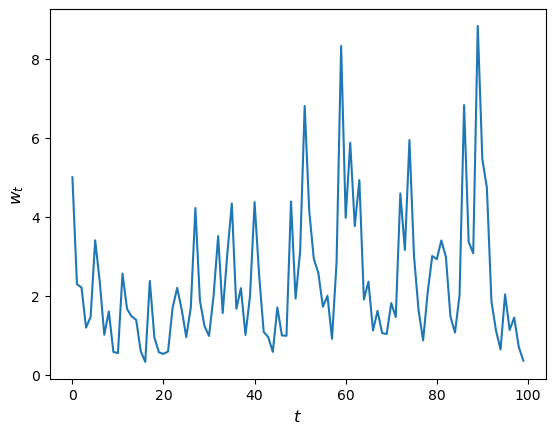

In [5]:
fig, ax = plt.subplots()

T = 100
w = np.empty(T)
w[0] = 5
for t in range(T-1):
    w[t+1] = h(w[t])

ax.plot(w)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$w_{t}$', fontsize=12)
plt.show()

Now let’s suppose that 

* we have a large population of households
* for each one, wealth evolves independently as above
* we want to know what median wealth will be in the long run

This is not easy to solve with pencil and paper, so we will use simulation
instead.

In particular, we will simulate a large number of households and then
calculate median wealth for this group.

Provided the simulation period is long enough, initial conditions
don’t matter.

- This is due to something called ergodicity, which we will discuss later 

So, in summary, we are going to simulate 200,000 households by

1. arbitrarily setting initial wealth of every household to 1 and  
1. simulating each one forward in time for 1,000 periods.  


Then we’ll calculate median wealth at the end period.

Here’s the code:

In [8]:
@njit
def compute_long_run_median(w0=1, T=1000, num_households=200_000):

    obs = np.empty(num_households)
    for i in range(num_households):
        w = w0
        for t in range(T):
            w = h(w)
        obs[i] = w

    return np.median(obs)

Let’s see how fast this runs:

In [10]:
%%time
compute_long_run_median()

CPU times: user 20.1 s, sys: 86.5 ms, total: 20.1 s
Wall time: 19.7 s


1.833939991597033

To speed this up, we’re going to parallelize it via multithreading.

To do so, we add the `parallel=True` flag and change `range` to `prange`:

In [11]:
from numba import prange

@njit(parallel=True)
def compute_long_run_median_parallel(w0=1, T=1000, num_households=200_000):

    obs = np.empty(num_households)
    for i in prange(num_households):
        w = w0
        for t in range(T):
            w = h(w)
        obs[i] = w

    return np.median(obs)

Let’s look at the timing:

In [12]:
%%time
compute_long_run_median_parallel()

CPU times: user 31 s, sys: 0 ns, total: 31 s
Wall time: 2.25 s


1.8339307902114306

The speed-up is significant.

### A Warning

Parallelization works well in the outer loop of the last example because the individual tasks inside the loop are independent of each other.

If this independence fails then parallelization is often problematic.

For example, each step inside the inner loop depends on the last step, so
independence fails, and this is why we use ordinary `range` instead of `prange`.


## Exercise 

The price of a European option obeys

$$
P = \beta^n \mathbb E \max\{ S_n - K, 0 \}
$$

where

1. $ \beta $ is a discount factor,  
1. $ n $ is the expiry date,  
1. $ K $ is the strike price and  
1. $ \{S_t\} $ is the price of the underlying asset at each time $ t $.  


Suppose that `n, β, K = 20, 0.99, 100`.

Assume that the stock price obeys

$$
\ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1}
$$

where

$$
\sigma_t = \exp(h_t), 
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$

Here $ \{\xi_t\} $ and $ \{\eta_t\} $ are IID and standard normal.

(This is a **stochastic volatility** model, where the volatility $ \sigma_t $
varies over time.)

Use the defaults `μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0`.

(Here `S0` is $ S_0 $ and `h0` is $ h_0 $.)

By generating $ M $ paths $ s_0, \ldots, s_n $, compute the Monte Carlo estimate

$$
\hat P_M 
    := \beta^n \mathbb E \max\{ S_n - K, 0 \} 
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
$$

of the price, applying Numba and parallelization.

In [25]:
for i in range(20):
    print("Solution below 😬")

Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬
Solution below 😬


## Solution 

With $ s_t := \ln S_t $, the price dynamics become

$$
s_{t+1} = s_t + \mu + \exp(h_t) \xi_{t+1}
$$

Using this fact, the solution can be written as follows.

In [26]:
from numpy.random import randn
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@njit(parallel=True)
def compute_call_price_parallel(β=β,
                                μ=μ,
                                S0=S0,
                                h0=h0,
                                K=K,
                                n=n,
                                ρ=ρ,
                                ν=ν,
                                M=M):
    current_sum = 0.0
    # For each sample path
    for m in prange(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

Try swapping between `parallel=True` and `parallel=False` and noting the run time.

If you are on a machine with many CPUs, the difference should be significant.